# Delivery of grocery orders report - Building and verifying the hypothesis

First, I had to prepare the data, which looks almost identical to exploration and cleaning of data described in my first report. The new part starts from the headline "Baseline prediction accuracy for cleaned data".

# Data exploration and cleaning

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [3]:
orders = pd.read_csv('orders.csv', sep=';')
route_segments = pd.read_csv('route_segments.csv',sep=";")

In [4]:
route_segments = route_segments.sort_values(by=["driver_id", "segment_start_time", "segment_end_time"])

In [5]:
route_segments = route_segments[~((route_segments['segment_type'] == 'STOP') & (route_segments['order_id'] == 0))]


In [6]:
def merge_consecutive_drives(df):
    # sort by driver_id and segment_start_time first
    df = df.sort_values(by=['driver_id', 'segment_start_time'])
    
    merged_rows = []
    previous_row = None
    for index, row in df.iterrows():
        if previous_row is not None and row['segment_type'] == 'DRIVE' and previous_row['segment_type'] == 'DRIVE':
            # extend the previous DRIVE segment's end_time to the current row's end_time
            previous_row['segment_end_time'] = row['segment_end_time']
        else:
            if previous_row is not None:
                merged_rows.append(previous_row)
            previous_row = row
    if previous_row is not None:
        merged_rows.append(previous_row)  # add the last row
    
    return pd.DataFrame(merged_rows)

route_segments = merge_consecutive_drives(route_segments)
route_segments.head(20)
for driver_id in route_segments['driver_id'].unique():
    df=route_segments[route_segments['driver_id']==driver_id]

In [7]:
def adjust_drive_segments(df):
    # initialize an empty list to store the adjusted segments
    adjusted_segments = []
    skip_next = False
    # iterate through the sorted DataFrame
    for i, (_, row) in enumerate(df.iterrows()):
        
        # if the segment is a DRIVE and overlaps with the next STOP segment
        if i < len(df) - 1:  # Ensure we don't go out of bounds
            next_row = df.iloc[i + 1]
            
            if row['segment_type'] == 'DRIVE' and next_row['segment_type'] == 'STOP' and row['segment_end_time'] > next_row['segment_start_time']:
                # adjust the current DRIVE to end when the STOP starts
                adjusted_drive = row.copy()
                adjusted_drive['segment_end_time'] = next_row['segment_start_time']
                adjusted_segments.append(adjusted_drive.to_dict())
                
                # insert the STOP segment
                adjusted_segments.append(next_row.to_dict())
                
                # create a new DRIVE segment starting when the STOP ends and ending when the original DRIVE was supposed to end
                new_drive = row.copy()
                new_drive["segment_id"] = None
                new_drive['segment_start_time'] = next_row['segment_end_time']
                adjusted_segments.append(new_drive.to_dict())
                skip_next = True
            elif skip_next:
                skip_next = False
            else:
                adjusted_segments.append(row.to_dict())
                
    
    # create a DataFrame from the adjusted segments
    adjusted_df = pd.DataFrame(adjusted_segments)
    
    return adjusted_df


route_segments = adjust_drive_segments(route_segments)

In [8]:
route_segments.loc[route_segments['order_id'] == 0, "order_id"] = None
route_segments["order_id"] = route_segments.groupby('driver_id')['order_id'].transform(lambda x: x.bfill())

In [9]:
# convert start and end times to datetime format
route_segments['segment_start_time'] = pd.to_datetime(route_segments['segment_start_time'])
route_segments['segment_end_time'] = pd.to_datetime(route_segments['segment_end_time'])

# calculate segment durations in minutes
route_segments['segment_duration_minutes'] = (route_segments['segment_end_time'] - route_segments['segment_start_time']).dt.total_seconds() / 60

In [10]:
# aggregate the total duration of DRIVE and STOP segments for each order_id
order_delivery_durations = route_segments.groupby('order_id')['segment_duration_minutes'].sum().reset_index(name='total_delivery_length_minutes')

# filter order_delivery_durations for total_delivery_length_minutes > 0 and <= 200
order_delivery_durations = order_delivery_durations[(order_delivery_durations['total_delivery_length_minutes'] > 0) & 
                                                    (order_delivery_durations['total_delivery_length_minutes'] <= 200)]


In [11]:
# calculate the 0.99 percentile of the total_delivery_length_minutes
percentile_99 = order_delivery_durations['total_delivery_length_minutes'].quantile(0.99)

# filter the DataFrame to only include rows with delivery lengths up to the 0.99 percentile
order_delivery_durations = order_delivery_durations[order_delivery_durations['total_delivery_length_minutes'] <= percentile_99]

In [12]:
# merge the orders DataFrame with the order_delivery_durations DataFrame on order_id
merged_data = pd.merge(orders[['order_id', 'sector_id']], 
                       order_delivery_durations[['order_id', 'total_delivery_length_minutes']],
                       on='order_id')


In [13]:
# aggregate the total delivery length by sector_id, calculating the mean delivery length for each sector
sector_delivery_lengths = merged_data.groupby('sector_id')['total_delivery_length_minutes'].mean().reset_index()
sector_delivery_lengths.rename(columns={'total_delivery_length_minutes': 'mean_delivery_time'}, inplace=True)


# Baseline prediction accuracy for cleaned data

First, I tried to use current prediction algorithm, that is calculating mean from all data, but this time with cleaned data. I wanted to use it as baseline prediction accuracy with which we could compare other solutions. Then  I calculated corresponding Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE), equal to 3.502 and 4.205, respectively and created a graph showing the distribution of errors (fig. 1)


In [14]:
#calculating baseline prediction accuracy for cleaned data
mean_delivery_time = order_delivery_durations['total_delivery_length_minutes'].mean()
order_delivery_durations['prediction_error_minutes'] = order_delivery_durations['total_delivery_length_minutes'] - mean_delivery_time
order_delivery_durations.head(20)

,order_id,total_delivery_length_minutes,prediction_error_minutes
0,1.0,2.733333,-6.077200
2,3.0,7.833333,-0.977200
3,4.0,1.350000,-7.460533
4,5.0,11.683333,2.872800
5,6.0,0.716667,-8.093867
7,8.0,9.150000,0.339467
8,9.0,11.016667,2.206133
9,10.0,8.183333,-0.627200
10,11.0,5.600000,-3.210533
11,12.0,14.400000,5.589467


Table 1. Sample of prediction errors for specific orders

In [15]:
# calculate Mean Absolute Error (MAE)
mae = order_delivery_durations['prediction_error_minutes'].abs().mean()

# calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt((order_delivery_durations['prediction_error_minutes']**2).mean())

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 3.502857774153951
Root Mean Squared Error (RMSE): 4.204764672131088


C:\Users\Grazyna\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


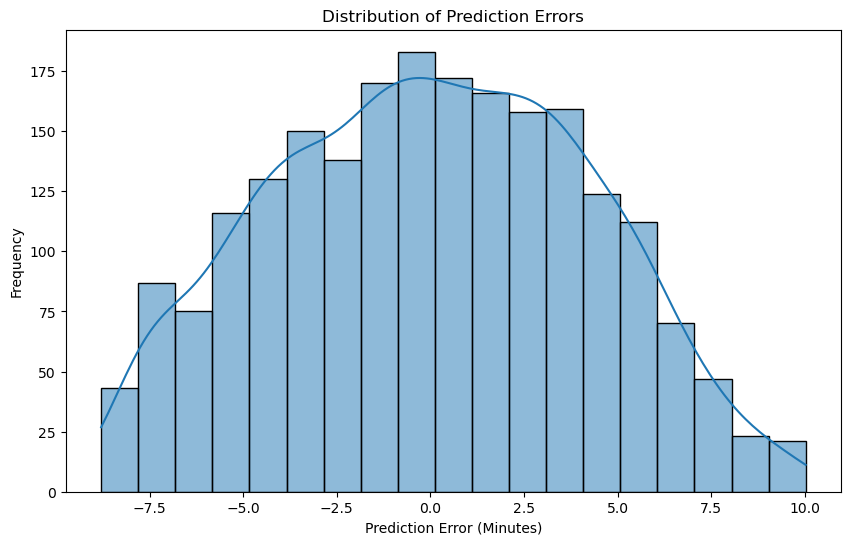

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(order_delivery_durations['prediction_error_minutes'], kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error (Minutes)')
plt.ylabel('Frequency')
plt.show()

Fig. 1. Histogram showing the distribution of prediction errors for current prediction method but with cleaned data

Next I wanted to predict delivery time based on sector and assess prediction errors of this strategy. Mean Absolute Error equals 3.480 and Mean Root Mean Squared Error equals 4.171. The distribution of errors is shown on histogram (fig. 2). Comparing that with the former method, the errors are slightly smaller, but the difference is very small (3.502 and 3.480 minutes for MAE)

In [17]:
# merge to get the predicted delivery time for each order based on its sector
merged_predictions = pd.merge(merged_data, sector_delivery_lengths, on='sector_id')
merged_predictions

,order_id,sector_id,total_delivery_length_minutes,mean_delivery_time
0,1,1,2.733333,9.571048
1,8,1,9.150000,9.571048
2,16,1,11.683333,9.571048
3,18,1,10.283333,9.571048
4,20,1,5.200000,9.571048
...,...,...,...,...
2139,2227,2,6.550000,8.384734
2140,2230,2,0.866667,8.384734
2141,2231,2,16.766667,8.384734
2142,2234,2,3.450000,8.384734


Table 2. Orders with corresponding delivery times and average delivery times calculated for each sector

In [18]:
merged_predictions['prediction_error'] = merged_predictions['total_delivery_length_minutes'] - merged_predictions['mean_delivery_time']
mae = merged_predictions['prediction_error'].abs().mean()
rmse = np.sqrt((merged_predictions['prediction_error']**2).mean())
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 3.4804761639235497
Root Mean Squared Error (RMSE): 4.17104150047125


C:\Users\Grazyna\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


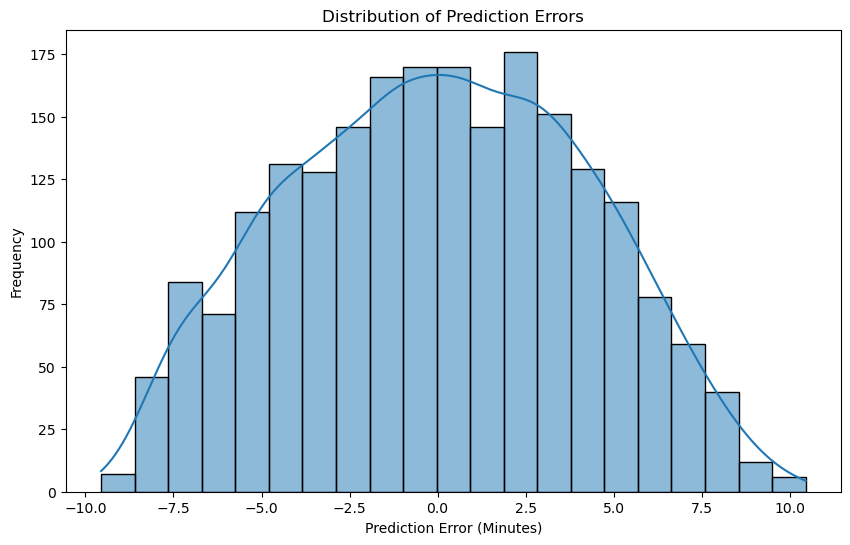

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_predictions['prediction_error'], kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error (Minutes)')
plt.ylabel('Frequency')
plt.show()


Fig. 2. Histogram showing the distribution of prediction errors for prediction method based on calculating means for each sector

Then I decided to do a similar analysis. This time calculating means for each driver. Mean Absolute Error is 3.384 and
Root Mean Squared Error is 4.054. Again it's slightly smaller than for the previous method.

In [20]:
# assuming route_segments and order_delivery_durations are your DataFrames
# first, create a DataFrame that maps order_id to driver_id (since an order can have multiple segments, drop duplicates)
driver_order_map = route_segments[['order_id', 'driver_id']].drop_duplicates()

# merge this mapping with order_delivery_durations to associate each order's delivery duration with its driver
driver_durations = pd.merge(order_delivery_durations, driver_order_map, on='order_id')
driver_durations

,order_id,total_delivery_length_minutes,prediction_error_minutes,driver_id
0,1.0,2.733333,-6.077200,1
1,3.0,7.833333,-0.977200,1
2,4.0,1.350000,-7.460533,1
3,5.0,11.683333,2.872800,3
4,6.0,0.716667,-8.093867,1
...,...,...,...,...
2139,2235.0,9.566667,0.756133,4
2140,2236.0,11.716667,2.906133,3
2141,2237.0,10.950000,2.139467,1
2142,2238.0,4.750000,-4.060533,2


Table 3

In [21]:
# calculate the mean delivery time per driver
mean_delivery_time_per_driver = driver_durations.groupby('driver_id')['total_delivery_length_minutes'].mean().reset_index(name='mean_delivery_time')
mean_delivery_time_per_driver

,driver_id,mean_delivery_time
0,1,7.281168
1,2,8.377549
2,3,9.436191
3,4,10.226963


Table 4

In [22]:
# Map new mean delivery times to orders
mean_map = mean_delivery_time_per_driver.set_index('driver_id')['mean_delivery_time'].to_dict()
driver_durations['mean_delivery_time'] = driver_durations['driver_id'].map(mean_map)

# Merge the mean delivery times back to get prediction for each order
#driver_durations = pd.merge(driver_durations, mean_delivery_time_per_driver, on='driver_id')
driver_durations


,order_id,total_delivery_length_minutes,prediction_error_minutes,driver_id,mean_delivery_time
0,1.0,2.733333,-6.077200,1,7.281168
1,3.0,7.833333,-0.977200,1,7.281168
2,4.0,1.350000,-7.460533,1,7.281168
3,5.0,11.683333,2.872800,3,9.436191
4,6.0,0.716667,-8.093867,1,7.281168
...,...,...,...,...,...
2139,2235.0,9.566667,0.756133,4,10.226963
2140,2236.0,11.716667,2.906133,3,9.436191
2141,2237.0,10.950000,2.139467,1,7.281168
2142,2238.0,4.750000,-4.060533,2,8.377549


Table 5

In [23]:
# Calculate prediction error for each order
driver_durations['prediction_error'] = driver_durations['total_delivery_length_minutes'] - driver_durations['mean_delivery_time']
driver_durations

,order_id,total_delivery_length_minutes,prediction_error_minutes,driver_id,mean_delivery_time,prediction_error
0,1.0,2.733333,-6.077200,1,7.281168,-4.547835
1,3.0,7.833333,-0.977200,1,7.281168,0.552165
2,4.0,1.350000,-7.460533,1,7.281168,-5.931168
3,5.0,11.683333,2.872800,3,9.436191,2.247142
4,6.0,0.716667,-8.093867,1,7.281168,-6.564502
...,...,...,...,...,...,...
2139,2235.0,9.566667,0.756133,4,10.226963,-0.660296
2140,2236.0,11.716667,2.906133,3,9.436191,2.280475
2141,2237.0,10.950000,2.139467,1,7.281168,3.668832
2142,2238.0,4.750000,-4.060533,2,8.377549,-3.627549


Table 6.

In [24]:
mae = driver_durations['prediction_error'].abs().mean()
rmse = np.sqrt((driver_durations['prediction_error']**2).mean())
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 3.3836363279134427
Root Mean Squared Error (RMSE): 4.054192202357584


C:\Users\Grazyna\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


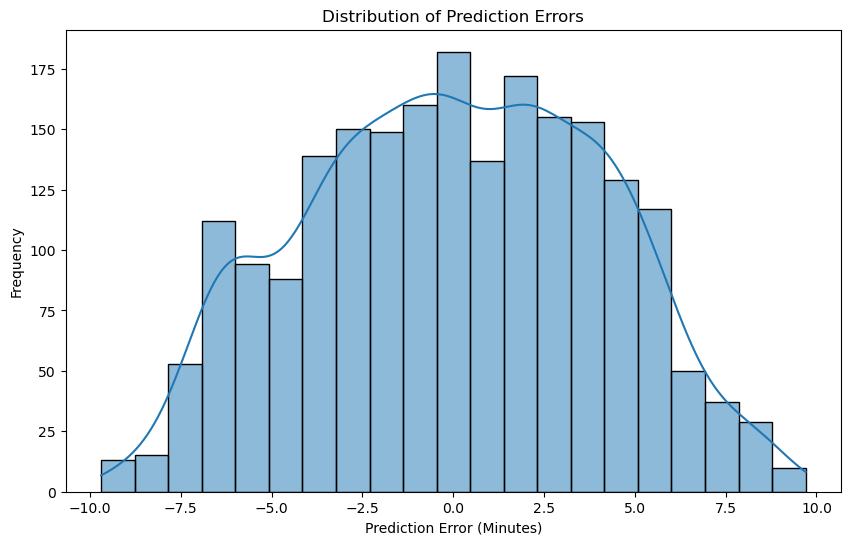

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(driver_durations['prediction_error'], kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error (Minutes)')
plt.ylabel('Frequency')
plt.show()

Fig. 3. Histogram showing distribution of errors for method based on averages for each driver